In [2]:
# Forked from shockspeare/NN_MLP.ipynb
%load_ext autoreload
%autoreload 2

In [3]:
from model.neural_network import DataPreprocessing, NN_wrapper
from pipeline import Dataset
import pandas as pd
from torch import nn
from datatools import data_quantization, check_dataframe
from pipeline.backtest import cross_validation
from matplotlib import pyplot as plt

In [4]:
dataset = Dataset.load('../../data/parsed')

In [5]:
aa = DataPreprocessing().fit_transform(dataset.fundamental)

KeyError: 'return_0+1'

In [ ]:
aa.isnull().any()

In [ ]:
fig, axs = plt.subplots(figsize=(3, 12), nrows=len(aa.columns), ncols=1)
for ax, col in zip(axs, aa.columns):
    aa[col].plot(ax=ax, kind='kde')

In [6]:
df = pd.concat([dataset.fundamental, dataset.ref_return], axis=1).dropna()

check_dataframe(df, expect_index=['day', 'asset'])

In [7]:
df['return_0+1'] = df['return'].shift(2*54).fillna(0)

In [12]:
train_lookback = 64
eval_lookback = 16
n_epoch = 100
lr = 0.001
criterion = nn.MSELoss()
# optimizer = 'LBFGS'
optimizer = 'ADAM'
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe', 'pcf', 'return_0+1']
n_asset = 54

pp = DataPreprocessing()
my_nn = NN_wrapper(pp, None, eval_lookback, train_lookback, optimizer=optimizer, learning_rate=lr,
                   criterion=criterion, n_epoch=n_epoch, n_asset=n_asset, n_feature=len(original_feature))

In [13]:
performance, pred_df = cross_validation(my_nn, feature_columns=original_feature, df=df.query(f'asset < {n_asset}'),
                                        per_eval_lookback=eval_lookback, train_lookback=train_lookback)

Validation on day 334, train_r2=0.0104, val_r2=-0.3902, val_cum_r2=-0.0903, val_cum_pearson=-0.0339:  28%|██▊       | 254/918 [02:39<06:58,  1.59it/s] 


KeyboardInterrupt: 

In [297]:
import numpy as np

sum((np.prod(x.data.shape) for x in my_nn.net.parameters()))

1957

The ending score for metric train_r2 is: 2.1880e-02
The ending score for metric val_cum_r2 is: -1.0370e-01
The ending score for metric val_cum_pearson is: -3.1285e-02


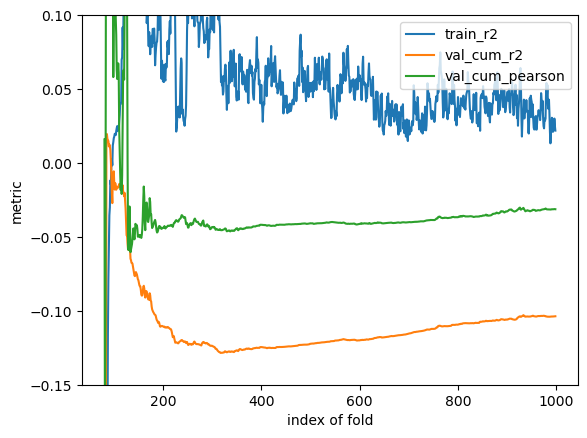

In [296]:
from visualization.metric import plot_performance

plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.15, 0.1])
plt.show()

In [238]:
lr = 0.001
llr = 0.05
train_lookback = 32
eval_lookback = 16
n_asset = 54

In [239]:
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
from torch import optim
from model.neural_network import oneDVerConvNet, idx, stupidNet

net = oneDVerConvNet(D_in=7, D_out=1, input_shape=(7, eval_lookback, n_asset), b_size=1)
# net = stupidNet(D_in=7)
adam = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
ascheduler = ExponentialLR(adam, gamma=0.999)
lbfgs = optim.LBFGS(net.parameters(), lr=llr)

X = df.loc[idx[1:(train_lookback + eval_lookback - 1), :n_asset - 1], original_feature]
y = df.loc[idx[eval_lookback:(train_lookback + eval_lookback - 1), :n_asset - 1], 'return']
X_transformed = pp.fit_transform(X)
# X_transformed = X.copy()
X_np = X_transformed.swaplevel(1, 0).sort_index(ascending=True).to_numpy().astype(np.float32)

In [225]:
from sklearn.linear_model import LinearRegression

X___ = X_np[(eval_lookback - 1) * n_asset:]
reg = LinearRegression().fit(X___, y)
print(reg.score(X___, y))
print(criterion(torch.tensor(y.values), torch.tensor(reg.predict(X___))))
# plt.scatter(y, reg.predict(X___))

0.053934353506776445
tensor(0.0009, dtype=torch.float64)


In [231]:
import torch

X_ult_list = []
y_ult_list = []

for i in range(train_lookback):
    X_np_day = X_np[i * n_asset:(i + eval_lookback) * n_asset, :]

    # shape (asset, days, feature) -> (ft, days, asset)
    X_np_tensor = X_np_day.reshape(n_asset, eval_lookback, -1).transpose([2, 1, 0])
    X_np_tensor = X_np_tensor[np.newaxis, :]  # add batch dimension
    X_ult_list.append(torch.from_numpy(X_np_tensor))
    y_ult_list.append(torch.tensor(y[i * n_asset:(i + 1) * n_asset].values).to(torch.float)[None, :])

y_ult = torch.cat(y_ult_list)
X_ult = torch.cat(X_ult_list)

In [255]:
def training_lol(epoch_total):
    for epoch in range(epoch_total):
        def closure():
            lbfgs.zero_grad()
            outputs = net(X_ult)
            loss = criterion(outputs, y_ult)
            loss.backward()
            return loss

        adam.zero_grad()
        # lbfgs.zero_grad()

        outputs = net(X_ult)
        loss = criterion(outputs, y_ult)
        # print(loss)
        loss.backward()

        adam.step()
        # lbfgs.step(closure)

        ascheduler.step()
        if epoch % 100 == 0:
            print(f'Epoch={epoch}, loss={loss.item()}, lr={adam.param_groups[0]["lr"]}')
    return outputs


outputs = training_lol(500)

Epoch=0, loss=0.00039799860678613186, lr=0.00036732772934619225
Epoch=100, loss=0.00040727376472204924, lr=0.0003323552449295445
Epoch=200, loss=0.00039476886740885675, lr=0.00030071241566430546
Epoch=300, loss=0.0004016796301584691, lr=0.00027208223223265714
Epoch=400, loss=0.0004084192914888263, lr=0.0002461778670932768


In [256]:
from sklearn.metrics import r2_score

r2_score(y_ult.numpy(), outputs.detach().numpy())

0.4826283293883858

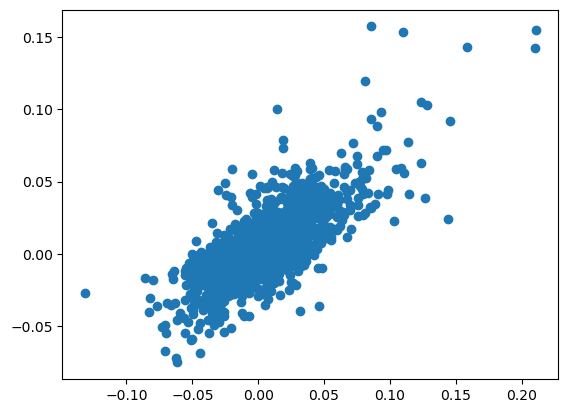

In [257]:
plt.scatter(y.values, outputs.detach().numpy())

In [251]:
sum((np.prod(x.data.shape) for x in net.parameters()))

43201

In [86]:
_asset = 0
_day = 1

print(X_transformed.loc[(_day, _asset)])
i = 0
X_np_day = X_np[i * n_asset:(i + eval_lookback) * n_asset, :]
X_np_tensor = X_np_day.reshape(n_asset, eval_lookback, -1).transpose([2, 1, 0])[np.newaxis, :]  # add batch dimension
print(X_np_tensor[0, :, _day - 1, _asset])

turnoverRatio        0.921681
transactionAmount    1.514109
pb                   0.094348
ps                   0.689068
pe_ttm               0.401113
pe                   0.317613
pcf                 -1.109144
Name: (1, 0), dtype: float64
[ 0.9216809   1.5141087   0.09434799  0.6890685   0.4011125   0.31761292
 -1.1091441 ]


In [85]:
tmp = X_np_day.reshape(n_asset, eval_lookback, -1)